https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [14]:
# Cell 1 — Configuration and Imports

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
import pandas as pd

DATA_DIR    = "D:/Ascl_Mimic_Data/Brain Tumor MRI"  # Change if needed
TRAIN_DIR   = os.path.join(DATA_DIR, "Training")
TEST_DIR    = os.path.join(DATA_DIR, "Testing")
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
SEED        = 42
NUM_CLIENTS = 3
LOCAL_EPOCHS = 5
ROUNDS      = 5

tf.keras.utils.set_random_seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE


In [15]:
# Cell 2 — Data Loading and Balanced Partitioning

def _list_class_dirs(root):
    return sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d)) and not d.startswith('.')])

def load_image_paths_and_labels(split_dir, class_names=None):
    if class_names is None:
        class_names = _list_class_dirs(split_dir)
    image_paths, labels = [], []
    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
                image_paths.append(os.path.join(class_dir, fname))
                labels.append(label_idx)
    return np.array(image_paths), np.array(labels), class_names

def create_balanced_splits(images, labels, num_clients=NUM_CLIENTS, class_names=None, seed=SEED):
    rng = np.random.default_rng(seed)
    class_to_idx = defaultdict(list)
    for i, y in enumerate(labels):
        class_to_idx[int(y)].append(i)
    for c in class_to_idx:
        rng.shuffle(class_to_idx[c])

    client_indices = [[] for _ in range(num_clients)]
    for c, idxs in class_to_idx.items():
        total = len(idxs)
        per_client = total // num_clients
        remainder = total % num_clients
        if remainder:
            print(f"[warn] Class {class_names[c] if class_names else c}: "
                  f"dropping {remainder} samples to keep exact balance ({total} -> {per_client*num_clients}).")
        for i in range(num_clients):
            start = i * per_client
            end = start + per_client
            client_indices[i].extend(idxs[start:end])

    client_data = []
    for idxs in client_indices:
        idxs = np.array(idxs, dtype=int)
        client_data.append((images[idxs], labels[idxs]))
    return client_data


In [16]:
# Cell 3 — Image Processing and Dataset Preparation with Strict Label Casting

def process_image(path, training=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
    return img

def preprocess_dataset(img_paths, labels, training=False):
    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)
    img_ds = tf.data.Dataset.from_tensor_slices(img_paths)
    img_ds = img_ds.map(lambda p: process_image(p, training), num_parallel_calls=AUTOTUNE)
    lbl_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((img_ds, lbl_ds))
    if training:
        ds = ds.shuffle(1024, seed=SEED)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# # Debug shapes in training dataset (uncomment to test)
#     for img_batch, label_batch in preprocess_dataset(train_image_paths[:BATCH_SIZE], train_labels[:BATCH_SIZE], True).take(1):
#         print(f"Image batch shape: {img_batch.shape}, Label batch shape: {label_batch.shape}, Label dtype: {label_batch.dtype}")


In [17]:
# Cell 4 — Load Data and Prepare Client Splits

train_image_paths, train_labels, class_names = load_image_paths_and_labels(TRAIN_DIR)
test_image_paths, test_labels, _ = load_image_paths_and_labels(TEST_DIR, class_names=class_names)
NUM_CLASSES = len(class_names)

client_data = create_balanced_splits(train_image_paths, train_labels, NUM_CLIENTS, class_names, SEED)

# Print per-client class distribution for sanity check
for cid, (_, lbls) in enumerate(client_data):
    counts = np.bincount(lbls, minlength=NUM_CLASSES)
    print(f"Client {cid}: total={len(lbls)} per-class={counts}")
print(f"Global test set size: {len(test_image_paths)}")

# Debug shapes in training dataset (uncomment to test)
for img_batch, label_batch in preprocess_dataset(train_image_paths[:BATCH_SIZE], train_labels[:BATCH_SIZE], True).take(1):
    print(f"Image batch shape: {img_batch.shape}, Label batch shape: {label_batch.shape}, Label dtype: {label_batch.dtype}")



[warn] Class glioma: dropping 1 samples to keep exact balance (1321 -> 1320).
[warn] Class meningioma: dropping 1 samples to keep exact balance (1339 -> 1338).
[warn] Class notumor: dropping 2 samples to keep exact balance (1595 -> 1593).
[warn] Class pituitary: dropping 2 samples to keep exact balance (1457 -> 1455).
Client 0: total=1902 per-class=[440 446 531 485]
Client 1: total=1902 per-class=[440 446 531 485]
Client 2: total=1902 per-class=[440 446 531 485]
Global test set size: 1311
Image batch shape: (32, 224, 224, 3), Label batch shape: (32, 4), Label dtype: <dtype: 'float64'>


Per-client class counts:
           glioma  meningioma  notumor  pituitary
Client 0     440         446      531        485
Client 1     440         446      531        485
Client 2     440         446      531        485


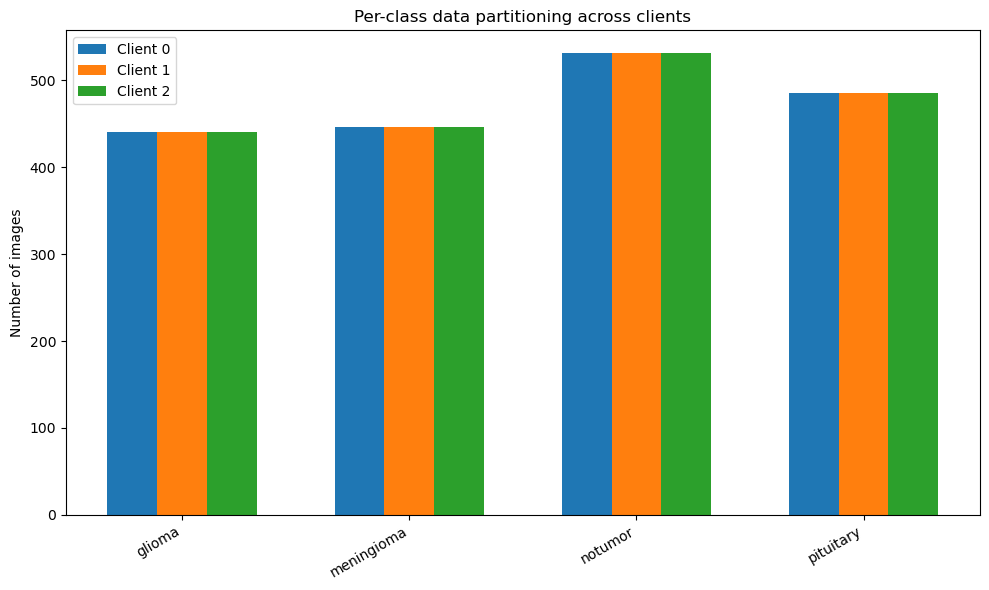

In [18]:
# Cell 5 — Visualize Data Distribution Across Clients

counts_arr = np.zeros((NUM_CLIENTS, NUM_CLASSES), dtype=int)
for cid, (_, lbls) in enumerate(client_data):
    counts_arr[cid] = np.bincount(lbls, minlength=NUM_CLASSES)

df_counts = pd.DataFrame(counts_arr, index=[f"Client {i}" for i in range(NUM_CLIENTS)], columns=class_names)
print("Per-client class counts:\n", df_counts)

x = np.arange(NUM_CLASSES)
width = 0.22
offsets = np.linspace(-width, width, NUM_CLIENTS)
plt.figure(figsize=(10, 6))
for cid in range(NUM_CLIENTS):
    plt.bar(x + offsets[cid], counts_arr[cid], width, label=f"Client {cid}")
plt.xticks(x, class_names, rotation=30, ha="right")
plt.ylabel("Number of images")
plt.title("Per-class data partitioning across clients")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Cell 6 — Define CNN Model

def create_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = create_model(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
model.summary()


c:\Users\amint\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Cell 7 — Manual Federated Training Loop with Debugging Checks
start_time = tf.timestamp()
global_model = create_model()
global_weights = global_model.get_weights()

for round_num in range(ROUNDS):
    print(f"\n### Federated Round {round_num + 1} ###")
    client_weights_list = []
    client_sizes = []

    for cid, (images, labels) in enumerate(client_data):
        print(f"Training on Client {cid} with {len(images)} samples")
        
        client_model = create_model()
        client_model.set_weights(global_weights)

        train_split = int(0.8 * len(images))
        train_imgs = images[:train_split]
        train_lbls = labels[:train_split].astype(np.int32)  # ensure int32
        val_imgs = images[train_split:]
        val_lbls = labels[train_split:].astype(np.int32)

        train_ds = preprocess_dataset(train_imgs, train_lbls, training=True)
        val_ds = preprocess_dataset(val_imgs, val_lbls, training=False)

        # Debug shapes before fit (uncomment to inspect)
        for imgs, lbls in train_ds.take(1):
            print(f"Train batch images: {imgs.shape}, labels: {lbls.shape}, label dtype: {lbls.dtype}")

        client_model.fit(train_ds, epochs=LOCAL_EPOCHS, validation_data=val_ds, verbose=1)

        client_weights_list.append(client_model.get_weights())
        client_sizes.append(len(train_imgs))

    # Federated Averaging of weights
    new_global_weights = []
    total_samples = sum(client_sizes)

    for weights_tuple in zip(*client_weights_list):
        weighted_sum = np.sum([w * size for w, size in zip(weights_tuple, client_sizes)], axis=0)
        new_global_weights.append(weighted_sum / total_samples)

    global_weights = new_global_weights
    global_model.set_weights(global_weights)
end_time = tf.timestamp()

print(f"\nTotal training time: {end_time - start_time:.2f} seconds")


### Federated Round 1 ###
Training on Client 0 with 1902 samples
Train batch images: (32, 224, 224, 3), labels: (32, 4), label dtype: <dtype: 'float64'>
Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step - accuracy: 0.4197 - auc: 0.6947 - loss: 1.3398 - val_accuracy: 0.0026 - val_auc: 0.3792 - val_loss: 1.7217
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.6215 - auc: 0.8889 - loss: 0.7769 - val_accuracy: 0.3570 - val_auc: 0.6182 - val_loss: 1.3948
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.6898 - auc: 0.9093 - loss: 0.7067 - val_accuracy: 0.3990 - val_auc: 0.6728 - val_loss: 1.2881
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 277ms/step - accuracy: 0.7333 - auc: 0.9288 - loss: 0.6239 - val_accuracy: 0.3517 - val_auc: 0.6781 - val_loss: 1.2747
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step - accuracy: 0.7505 - auc: 0.9404 - loss: 0.5603 - val_accuracy: 0.5748 - val_auc: 0.8455 - val_loss: 0.9294
Training on Client 1 with 1902 samples
Train b

41/41 - 4s - 109ms/step - accuracy: 0.9527 - auc: 0.9946 - loss: 0.1705

Test Loss: 0.1705, Accuracy: 0.9527, AUC: 0.9946

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.91      0.91      0.91       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.98      0.96      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



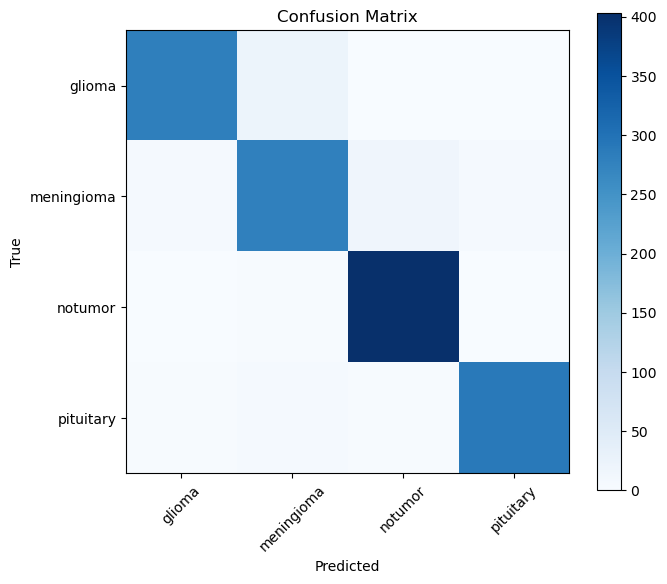

: 

In [ ]:
test_ds = preprocess_dataset(test_image_paths, test_labels.astype(np.int32), training=False)
loss, accuracy, auc = global_model.evaluate(test_ds, verbose=2)
print(f"\nTest Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

y_true, y_pred = [], []
for x_batch, y_batch in test_ds:
    preds = global_model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Ensure y_true and y_pred are 1D integer arrays (in case y_true is one-hot)
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)
if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


modify the pdf

In [1]:
pip install PyPDF2

Note: you may need to restart the kernel to use updated packages.


In [3]:
from PyPDF2 import PdfReader

reader = PdfReader(r"D:\EUP\References\Lifestyle_BARI 115_2025-06-04.pdf")
number_of_pages = len(reader.pages)
page = reader.pages[0]
text = page.extract_text()

In [6]:
pip install PyMuPDF

   ---------------------------------------- 0.0/18.7 MB ? eta -:--:--
   - -------------------------------------- 0.8/18.7 MB 5.6 MB/s eta 0:00:04
   ---- ----------------------------------- 2.1/18.7 MB 6.5 MB/s eta 0:00:03
   ------ --------------------------------- 3.1/18.7 MB 6.2 MB/s eta 0:00:03
   -------- ------------------------------- 4.2/18.7 MB 5.9 MB/s eta 0:00:03
   ----------- ---------------------------- 5.5/18.7 MB 6.0 MB/s eta 0:00:03
   --------------- ------------------------ 7.1/18.7 MB 6.1 MB/s eta 0:00:02
   ------------------ --------------------- 8.7/18.7 MB 6.3 MB/s eta 0:00:02
   --------------------- ------------------ 10.0/18.7 MB 6.3 MB/s eta 0:00:02
   ------------------------ --------------- 11.3/18.7 MB 6.3 MB/s eta 0:00:02
   -------------------------- ------------- 12.6/18.7 MB 6.4 MB/s eta 0:00:01
   ------------------------------ --------- 14.2/18.7 MB 6.4 MB/s eta 0:00:01
   ------------------------------- -------- 14.7/18.7 MB 6.5 MB/s eta 0:00:01
 

In [17]:
pip install frontend



   -------------------- ------------------- 2/4 [starlette]
   ---------------------------------------- 4/4 [frontend]

Note: you may need to restart the kernel to use updated packages.


In [7]:
import fitz  # PyMuPDF

# Open the PDF file
doc = fitz.open(r"D:/EUP/References/Lifestyle_BARI 115_2025-06-04.pdf")
page = doc[0]  # first page

# Approximate rectangles covering the first two "No" answers (x0,y0,x1,y1)
# You need to adjust these coordinates after testing
rects_to_replace = [
    fitz.Rect(200, 680, 230, 700),  # example coords for first "No"
    fitz.Rect(200, 660, 230, 680),  # example coords for second "No"
]



In [8]:
for rect in rects_to_replace:
    # Redact old "No"
    page.add_redact_annot(rect, fill=(1, 1, 1))  # white fill
page.apply_redactions()

# Insert new "Yes" text on those positions
for rect in rects_to_replace:
    page.insert_text(rect.tl, "Yes", fontsize=12, fontname="helv", color=(0, 0, 0))

# Save as new PDF so original stays unchanged
doc.save("Lifestyle_BARI-115_2025-06-04_modified.pdf")
doc.close()
print("First two 'No' answers changed to 'Yes' and saved as 'Lifestyle_BARI-115_2025-06-04_modified.pdf'")

First two 'No' answers changed to 'Yes' and saved as 'Lifestyle_BARI-115_2025-06-04_modified.pdf'


In [11]:
pip install reportlab

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ---------------- ----------------------- 0.8/2.0 MB 2.8 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/2.0 MB 1.9 MB/s eta 0:00:01
   -------------------------------- ------- 1.6/2.0 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 2.3 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
from PyPDF2 import PdfReader
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter

# Step 1: Extract text
reader = PdfReader(r"D:\EUP\References\Lifestyle_BARI 115_2025-06-04.pdf")
page = reader.pages[0]
text = page.extract_text()

print(text[180:200])  # <-- check what’s around index 184

# Step 2: Replace "No" at position 184–186 with "Yes"
new_text = text[:184] + "Yes" + text[186:]

# Step 3: Save to new PDF
output_path = r"Modified.pdf"
c = canvas.Canvas(output_path, pagesize=letter)

y = 750
for line in new_text.split("\n"):
    c.drawString(50, y, line)
    y -= 20

c.save()


o):
No
Dieta: meno d
